<a href="https://colab.research.google.com/github/MackPreston/iot-traffic-analysis/blob/main/notebooks/known_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Known Attack Analysis

**This notebook covers basic pre-processing and analysis of known attack traffic.**

Note: the original 50c7bf005639.csv source file had a few extra commas that needed to be removed in order to load the csv properly.

TODO - investigate *-packet-anomaly.txt files - what are they for?

In [10]:
import sys
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
import torch
time_to_date = lambda t: datetime.utcfromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S')


In [11]:
# Load device_info from file
mac_to_filename = lambda s: f"{s.lower().replace(':', '')}.csv"

filepath = "device_info.csv"
device_info = pd.read_csv(filepath, index_col=None, delimiter=',')
device_info['annotation_file'] = device_info['mac'].map(mac_to_filename)
device_info

,mac,ip,device_type,annotation_file
0,ec:1a:59:83:28:11,192.168.1.165,WEMO Motion Sensor,ec1a59832811.csv
1,ec:1a:59:79:f4:89,192.168.1.223,WEMO Power Switch,ec1a5979f489.csv
2,00:16:6c:ab:6b:88,192.168.1.248,Samsung Camera,00166cab6b88.csv
3,50:c7:bf:00:56:39,192.168.1.227,TP Link Plug,50c7bf005639.csv
4,70:ee:50:18:34:43,192.168.1.241,Netatmo Camera,70ee50183443.csv
5,00:17:88:2B:9A:25,192.168.1.129,Huebulb,0017882b9a25.csv
6,44:65:0D:56:CC:D3,192.168.1.239,AmazonEcho,44650d56ccd3.csv
7,F4:F5:D8:8F:0A:3C,192.168.1.119,chromecast,f4f5d88f0a3c.csv
8,74:C6:3B:29:D7:1D,192.168.1.163,ihome,74c63b29d71d.csv
9,D0:73:D5:01:83:08,192.168.1.118,lifx,d073d5018308.csv


In [12]:
file_pattern = '*.csv'
glob_path = os.path.join(os.getcwd(), 'annotations', file_pattern)
file_list = glob.glob(glob_path)

li = []
for filepath in file_list:
    print(f"loading {filepath}")
    df = pd.read_csv(filepath, index_col=None, delimiter=',', header=0, names=[
      'start_time', 'end_time', 'description', 'attack_type'])
    
    filename = os.path.basename(filepath)
    df['annotation_file'] = filename
    li.append(df)

known_attacks = pd.concat(li, axis=0, ignore_index=True)
# Convert time units to match tranalyzer
known_attacks.sort_values(by=['start_time'], inplace=True, ignore_index=True)
known_attacks["duration"] = known_attacks['end_time'] - known_attacks['start_time']

# Enrich attack meta-data with device meta-data
known_attacks = known_attacks.set_index('annotation_file').join(device_info.set_index('annotation_file'))
known_attacks.reset_index()

loading /mnt/e/iot-traffic-analysis/annotations/00166cab6b88.csv
loading /mnt/e/iot-traffic-analysis/annotations/0017882b9a25.csv
loading /mnt/e/iot-traffic-analysis/annotations/44650d56ccd3.csv
loading /mnt/e/iot-traffic-analysis/annotations/50c7bf005639.csv
loading /mnt/e/iot-traffic-analysis/annotations/70ee50183443.csv
loading /mnt/e/iot-traffic-analysis/annotations/74c63b29d71d.csv
loading /mnt/e/iot-traffic-analysis/annotations/d073d5018308.csv
loading /mnt/e/iot-traffic-analysis/annotations/ec1a5979f489.csv
loading /mnt/e/iot-traffic-analysis/annotations/ec1a59832811.csv
loading /mnt/e/iot-traffic-analysis/annotations/f4f5d88f0a3c.csv


,annotation_file,start_time,end_time,description,attack_type,duration,mac,ip,device_type
0,00166cab6b88.csv,1527835334,1527835936,Localfeatures|Allfeatures|Arpfeatures,ArpSpoof1L2D,602,00:16:6c:ab:6b:88,192.168.1.248,Samsung Camera
1,00166cab6b88.csv,1527836944,1527837544,Localfeatures|Allfeatures|Arpfeatures,ArpSpoof10L2D,600,00:16:6c:ab:6b:88,192.168.1.248,Samsung Camera
2,00166cab6b88.csv,1527860996,1527861596,localTcpPort49152|Tcpfeatures|Localfeatures|Al...,TcpSynDevice1L2D,600,00:16:6c:ab:6b:88,192.168.1.248,Samsung Camera
3,00166cab6b88.csv,1527862604,1527863204,localTcpPort49152|Tcpfeatures|Localfeatures|Al...,TcpSynDevice10L2D,600,00:16:6c:ab:6b:88,192.168.1.248,Samsung Camera
4,00166cab6b88.csv,1527864215,1527864815,localTcpPort49152|Tcpfeatures|Localfeatures|Al...,TcpSynDevice100L2D,600,00:16:6c:ab:6b:88,192.168.1.248,Samsung Camera
...,...,...,...,...,...,...,...,...,...
219,f4f5d88f0a3c.csv,1540314670,1540315270,Udpfeatures|Internetfeatures|Allfeatures|Inter...,Ssdp10W2D2W,600,F4:F5:D8:8F:0A:3C,192.168.1.119,chromecast
220,f4f5d88f0a3c.csv,1540315870,1540316470,Udpfeatures|Internetfeatures|Allfeatures|Inter...,Ssdp100W2D2W,600,F4:F5:D8:8F:0A:3C,192.168.1.119,chromecast
221,f4f5d88f0a3c.csv,1540452323,1540452924,Udpfeatures|Internetfeatures|Allfeatures|Inter...,Ssdp1W2D2W,601,F4:F5:D8:8F:0A:3C,192.168.1.119,chromecast
222,f4f5d88f0a3c.csv,1540453525,1540454125,Tcpfeatures|Internetfeatures|Allfeatures|Inter...,TcpSynReflection1W2D2W,600,F4:F5:D8:8F:0A:3C,192.168.1.119,chromecast


2018-10-25 10:30:48
2018-06-01 04:00:43


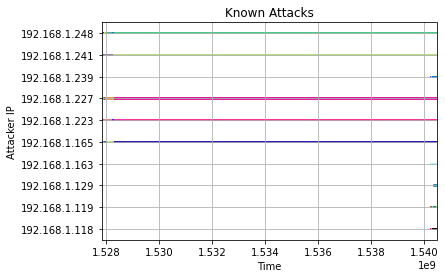

In [13]:
fig, gnt = plt.subplots() 

last_time = max(known_attacks.end_time)
first_time = min(known_attacks.start_time)
print(time_to_date(last_time))
print(time_to_date(first_time))

attack_groupings = known_attacks.groupby(['ip'])
attacks_by_ip = [attack_groupings.get_group(g) for g in attack_groupings.groups]

y_indices = np.arange(len(attacks_by_ip))

gnt.set_title("Known Attacks")
gnt.set_ylim(0, len(attacks_by_ip)) 
gnt.set_xlim(first_time, last_time) 

gnt.set_xlabel('Time') 
gnt.set_ylabel('Attacker IP')

ip_groups = known_attacks.groupby(['ip'])
group_ips = list(ip_groups.groups.keys())
gnt.set_yticks(y_indices + 0.5) 
gnt.set_yticklabels(group_ips) 

gnt.grid(True) 

for i in y_indices:
  tuples = [tuple(f) for f in attacks_by_ip[i][['start_time', 'end_time']].values]
  for t in tuples:
    gnt.broken_barh([t], (i + 0.45, 0.1), facecolors =(np.random.rand(3,))) 
